In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Data ajustment

In [66]:
csvpath  = r'D:\Downloads\C19\Data_Entry_2017.csv'
base_dir = os.path.abspath(r'D:\Downloads\C19\3channel')

In [67]:
# read metadata
df = pd.read_csv(csvpath)
# get images path
all_image_paths = {os.path.basename(x): x for x in
                        glob(os.path.join(base_dir, '*', '*.png'))}

In [68]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [69]:
# data
df['path'] = df['Image Index'].map(all_image_paths.get)
df['path'] = df['path'].astype('str')

df['Patient Age'] = df['Patient Age'].map(lambda x: int(x[:-1]))
df['Gender'] = pd.get_dummies(df['Patient Gender'])['F']
df['View']   = pd.get_dummies(df['View Position'])['AP']

In [70]:
#labels

df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|')[0] if '|' in x else x)

# labels binary coding
labels = np.unique(df['Finding Labels'])
labels = [x for x in labels if len(x)>0]
print('Labels ({}.'.format(labels))
for c_label in labels:
    if len(c_label) > 1:  # leave out empty labels
        df[c_label] = df['Finding Labels'].map(
            lambda finding: 1.0 if c_label in finding else 0)

Labels (['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'].


No Findings: 60412
Atelectasis: 4212
Cardiomegaly: 1094
Consolidation:1314 
Edema: 634
Effusion: 3959
Emphysema: 895
Fibrosis: 1215 
Hernia: 156
Infiltration: 11787
Mass: 2920 
Nodule: 3003 
Pleural_Thickening: 1217 
Pneumonia: 310 
Pneumothorax: 2199 

In [71]:
df1 = df[df['Finding Labels'] == 'No Finding'].sample(11787)
df2 = df[df['Finding Labels'] == 'Infiltration']
df = pd.concat((df1,df2))
df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
14800,00003866_000.png,No Finding,0,3866,62,F,PA,2544,3056,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
72580,00017893_001.png,No Finding,1,17893,70,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
83965,00020641_000.png,No Finding,0,20641,55,F,PA,2338,2521,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
86618,00021373_006.png,No Finding,6,21373,67,F,PA,2532,2764,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23065,00006098_000.png,No Finding,0,6098,33,F,PA,1744,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [72]:
# I just converted them to lists because I prefer work w it, 
# u can keep working w dataframe if u feel more confortable w it

labels = df['Finding Labels'].tolist()
imagespath = df['path'].tolist()

In [73]:
# I added three attributes to find more correlations 
# learning from only the gender and the view could not add something useful
input2 = df[['Patient Age', 'Gender', 'View']] 
input2 = input2.values.tolist()

In [74]:
# metadata should be normalized before training
scaler = MinMaxScaler()
input2scaled = scaler.fit_transform(input2)

In [75]:
# I suggest start with a simple binary classification (0 if disease, else 1)
# once the model is stable we can move to a multiclassification case
Y = [ 0 if x == 'No Finding' else 1 for x in labels]
Y = tf.keras.utils.to_categorical(Y)
#print(Y.count(1), Y.count(0)) # found them balanced

In [76]:
labels = [ x if x == 'No Finding' else 'Disease' for x in labels]

In [77]:
#(Thiago) I prefer to use dataframes haha
data_frame           = pd.DataFrame()
data_frame['path']   = df['path']
data_frame['Y0']     = Y[:,0]
#data_frame['Y1']     = Y[:,1]
data_frame['Finding Labels'] = labels

In [78]:
for index, row in df.iterrows():
    if(os.path.isfile(row['path']) == False):
        df.drop(index, inplace=True)

In [79]:
image_count = df.shape[0]
image_count

23473

In [80]:
data_frame[data_frame['Finding Labels'] == 'No Finding'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11787 entries, 14800 to 31518
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   path            11787 non-null  object 
 1   Y0              11787 non-null  float32
 2   Finding Labels  11787 non-null  object 
dtypes: float32(1), object(2)
memory usage: 322.3+ KB


## Train, Validation and Test datasets

Train share: 70%
Validation share: 15%
Test share: 15%

In [81]:
seed = 7
np.random.seed(seed)

In [82]:
#train_validation test split for both inputs
train_val_df, test_df = train_test_split(data_frame, 
                                     test_size = 0.15, 
                                     random_state = seed)

In [94]:
BATCH_SIZE = 256
IMG_SIZE = (224, 224)
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [95]:
core_idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           validation_split=0.25
                                                           #samplewise_center=True, 
                                                           #samplewise_std_normalization=True, 
                                                           #horizontal_flip = True, 
                                                           #vertical_flip = False, 
                                                           #height_shift_range= 0.05, 
                                                           #width_shift_range=0.1, 
                                                           #rotation_range=5, 
                                                           #shear_range = 0.1,
                                                           #fill_mode = 'reflect',
                                                           #zoom_range=0.15,
                                                            
                                                          )


In [96]:
train_gen = core_idg.flow_from_dataframe(train_val_df, 
                                         directory=None,
                                         x_col = 'path',
                                         y_col = 'Finding Labels',
                                         class_mode = 'categorical',
                                         #classes = labels,
                                         subset="training",
                                         shuffle=True,
                                         target_size = IMG_SIZE,
                                         #color_mode = 'grayscale',
                                         batch_size = BATCH_SIZE)

Found 14967 validated image filenames belonging to 2 classes.


C:\Users\thiag\miniconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 82 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [97]:
val_gen = core_idg.flow_from_dataframe(train_val_df, 
                                         directory=None,
                                         x_col = 'path',
                                         y_col = 'Finding Labels',
                                         class_mode = 'categorical',
                                         #classes = labels,
                                         subset="validation",
                                         shuffle=True,
                                         target_size = IMG_SIZE,
                                         #color_mode = 'grayscale',
                                         batch_size = BATCH_SIZE)

Found 4988 validated image filenames belonging to 2 classes.


C:\Users\thiag\miniconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 82 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [98]:
core_idg_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                           #samplewise_center=True, 
                                                           #samplewise_std_normalization=True, 
                                                           #horizontal_flip = True, 
                                                           #vertical_flip = False, 
                                                           #height_shift_range= 0.05, 
                                                           #width_shift_range=0.1, 
                                                           #rotation_range=5, 
                                                           #shear_range = 0.1,
                                                           #fill_mode = 'reflect',
                                                           #zoom_range=0.15,
                                                          )

In [99]:
test_gen = core_idg.flow_from_dataframe(test_df, 
                                         directory=None,
                                         x_col = 'path',
                                         y_col = 'Finding Labels',
                                         class_mode = 'categorical',
                                         #classes = labels,
                                         shuffle=True,
                                         target_size = IMG_SIZE,
                                         #color_mode = 'grayscale',
                                         batch_size = BATCH_SIZE)

Found 3518 validated image filenames belonging to 2 classes.


C:\Users\thiag\miniconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 19 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [100]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(224, 224, 3)
)
base_model.trainable = False

In [101]:
# Model only with images

cnn =  tf.keras.Sequential()
cnn.add(base_model)
cnn.add(tf.keras.layers.GlobalAveragePooling2D())
cnn.add(tf.keras.layers.Dense(2048, kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
cnn.add(tf.keras.layers.Dropout(0.3))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
cnn.add(tf.keras.layers.Dropout(0.3))
cnn.add(tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
cnn.add(tf.keras.layers.Dropout(0.3))
cnn.add(tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
cnn.add(tf.keras.layers.Dropout(0.3))
cnn.add(tf.keras.layers.Dense(2, activation='softmax'))
model_cnn = tf.keras.models.Model(inputs = cnn.input, outputs = cnn.output)

adam = tf.keras.optimizers.Adam(learning_rate=0.001)
#RMSprop = tf.keras.optimizers.RMSprop(learning_rate=0.01)

model_cnn.compile(optimizer = adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [102]:
checkpoint_path = "D:\Downloads\C19\checkpoint\cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [103]:
logdir = "logs\\" + 'Adam_10e-3 - DP_0.3 - L2_10e-3 - 2048'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [104]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=val_gen.n//val_gen.batch_size
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
history = model_cnn.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[cp_callback,tensorboard_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 58 steps, validate for 19 steps
Epoch 1/25
 1/58 [..............................] - ETA: 13:43
Epoch 00001: saving model to D:\Downloads\C19\checkpoint\cp.ckpt
 1/58 [..............................] - ETA: 14:54

KeyboardInterrupt: 

In [32]:
test_gen.reset()
pred=model_cnn.predict_generator(test_gen, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
14/14 [==============================] - 39s 3s/step


In [33]:
pred_df = pd.DataFrame(pred)
pred_df = (pred_df>=0.5)*1
d = test_df['Y0']

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

In [35]:
print(classification_report(d,pred_df[0]))
print('\n')
print(confusion_matrix(d,pred_df[0]))

ValueError: Found input variables with inconsistent numbers of samples: [3537, 3519]

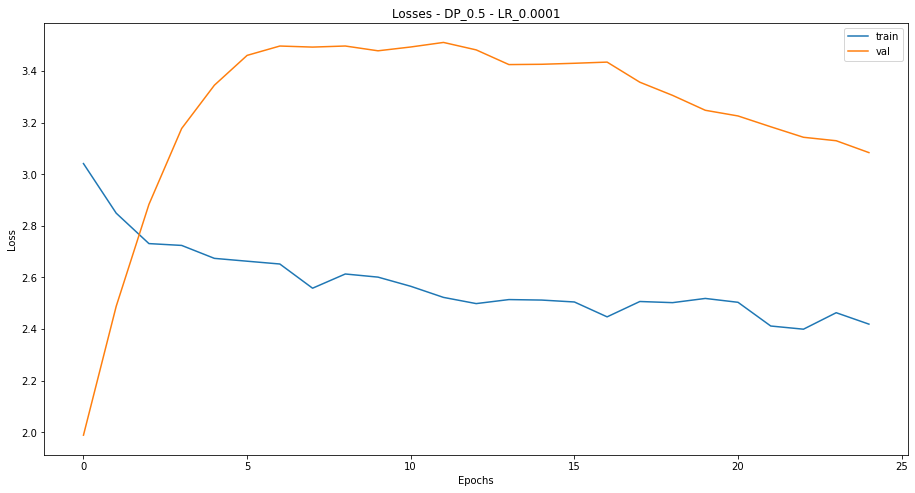

In [37]:
fig = plt.figure(figsize = (12,6))

ax = fig.add_axes([0,0,1,1])

ax.plot(np.arange(0,25),history.history['loss'])
ax.plot(np.arange(0,25),history.history['val_loss'])
ax.set_title('Losses - DP_0.5 - LR_0.0001')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(['train', 'val'])

In [1]:
tensorboard --logdir logs

SyntaxError: invalid syntax (<ipython-input-1-575f178ee557>, line 1)